支持向量机-实例
===

# 1.不平衡数据的处理

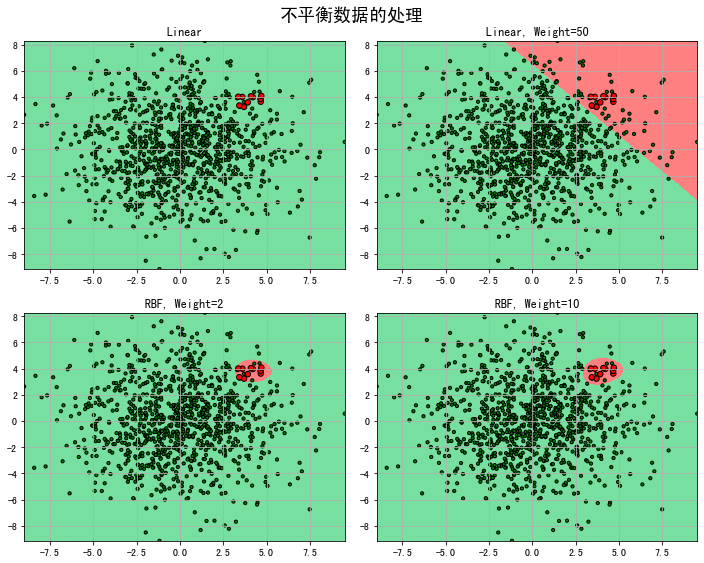

In [1]:
import numpy as np
from sklearn import svm
import matplotlib.colors
import matplotlib.pyplot as plt
from sklearn.exceptions import UndefinedMetricWarning
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
np.random.seed(0)   # 保持每次生成的数据相同

c1 = 990
c2 = 10
N = c1 + c2
x_c1 = 3*np.random.randn(c1, 2)
x_c2 = 0.5*np.random.randn(c2, 2) + (4, 4)
x = np.vstack((x_c1, x_c2))
y = np.ones(N)
y[:c1] = -1

# 显示大小
s = np.ones(N) * 30
s[:c1] = 10

# 分类器
clfs = [svm.SVC(C=1, kernel='linear'),
        svm.SVC(C=1, kernel='linear', class_weight={-1: 1, 1: 50}),
        svm.SVC(C=0.8, kernel='rbf', gamma=0.5, class_weight={-1: 1, 1: 2}),
        svm.SVC(C=0.8, kernel='rbf', gamma=0.5, class_weight={-1: 1, 1: 10})]
titles = 'Linear', 'Linear, Weight=50', 'RBF, Weight=2', 'RBF, Weight=10'

x1_min, x1_max = x[:, 0].min(), x[:, 0].max()  # 第0列的范围
x2_min, x2_max = x[:, 1].min(), x[:, 1].max()  # 第1列的范围
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]  # 生成网格采样点
grid_test = np.stack((x1.flat, x2.flat), axis=1)  # 测试点

cm_light = matplotlib.colors.ListedColormap(['#77E0A0', '#FF8080'])
cm_dark = matplotlib.colors.ListedColormap(['g', 'r'])
matplotlib.rcParams['font.sans-serif'] = [u'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 8), facecolor='w')
for i, clf in enumerate(clfs):
    clf.fit(x, y)

    y_hat = clf.predict(x)
    # show_accuracy(y_hat, y) # 正确率
    # show_recall(y, y_hat)   # 召回率

    # 画图
    plt.subplot(2, 2, i+1)
    grid_hat = clf.predict(grid_test)       # 预测分类值
    grid_hat = grid_hat.reshape(x1.shape)  # 使之与输入的形状相同
    plt.pcolormesh(x1, x2, grid_hat, cmap=cm_light, alpha=0.8)
    plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', s=s, cmap=cm_dark)      # 样本的显示
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.title(titles[i])
    plt.grid()
plt.suptitle(u'不平衡数据的处理', fontsize=18)
plt.tight_layout(1.5)
plt.subplots_adjust(top=0.92)

# 2.线性

<Figure size 720x720 with 0 Axes>

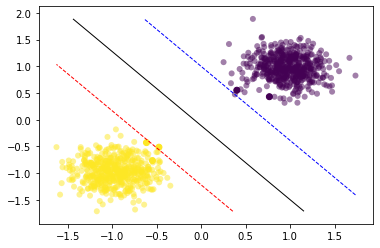

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler

class SMOModel:
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X
        self.y = y
        self.C = C
        self.kernel = kernel  # 核函数
        self.alphas = alphas  # 拉格朗日乘子
        self.b = b
        self.errors = errors
        self._obj = []
        self.m = len(self.X)

def linear_kernel(x, y, b=1):
    return x @ y.T + b

def gaussian_kernel(x, y, sigma=1):
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- np.linalg.norm(x - y) / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- np.linalg.norm(x - y, axis=1) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], axis=2) / (2 * sigma ** 2))
    return result

## 定义目标函数
def objective_function(alphas, target, kernel, X_train):
    return np.sum(alphas) - 0.5 * np.sum(target * target * kernel(X_train, X_train) * alphas * alphas)

def decision_function(alphas, target, kernel, X_train, x_test, b):
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r')):
    """Plots the model's decision boundary on the input axes object.
    Range of decision boundary grid is determined by the training data.
    Returns decision boundary grid and axes object (`grid`, `ax`)."""

    # Generate coordinate grid of shape [resolution x resolution]
    # and evaluate the model over the entire space
    xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
    yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
    grid = [[decision_function(model.alphas, model.y,
                               model.kernel, model.X,
                               np.array([xr, yr]), model.b) for yr in yrange] for xr in xrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xrange, yrange, grid, (-1, 0, 1), linewidths=(1, 1, 1),
               linestyles=('--', '-', '--'), colors=colors)
    ax.scatter(model.X[:,0], model.X[:,1],
               c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.5)

    # Plot support vectors (non-zero alphas)
    # as circled points (linewidth > 0)
    mask = model.alphas != 0.0
    ax.scatter(model.X[:,0][mask], model.X[:,1][mask],
               c=model.y[mask], cmap=plt.cm.viridis)

    return grid, ax

def take_step(i1, i2, model):

    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model

    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2

    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22

    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H

    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2

    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C

    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model

    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)

    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b

    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2

    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0

    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new

    # Update model threshold
    model.b = b_new

    return 1, model

def examine_example(i2, model):

    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):

        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

    return 0, model

def train(model):

    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1

    return model

'''
线性可分
'''
x_len, y_len = 5, 10
X_train, y = make_blobs(n_samples=1000, centers=2,
                        n_features=2, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1
C = 1000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error
np.random.seed(0)
output = train(model)

plt.figure(figsize=(10,10),facecolor='w')
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

# 3.非线性

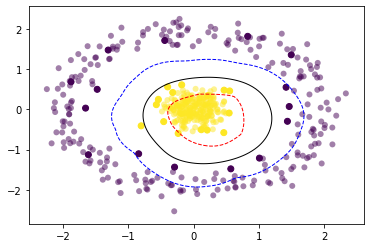

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from sklearn.preprocessing import StandardScaler

class SMOModel:
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X
        self.y = y
        self.C = C
        self.kernel = kernel  # 核函数
        self.alphas = alphas  # 拉格朗日乘子
        self.b = b
        self.errors = errors
        self._obj = []
        self.m = len(self.X)

def linear_kernel(x, y, b=1):
    return x @ y.T + b

def gaussian_kernel(x, y, sigma=1):
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- np.linalg.norm(x - y) / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- np.linalg.norm(x - y, axis=1) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], axis=2) / (2 * sigma ** 2))
    return result

## 定义目标函数
def objective_function(alphas, target, kernel, X_train):
    return np.sum(alphas) - 0.5 * np.sum(target * target * kernel(X_train, X_train) * alphas * alphas)

def decision_function(alphas, target, kernel, X_train, x_test, b):
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r')):
    """Plots the model's decision boundary on the input axes object.
    Range of decision boundary grid is determined by the training data.
    Returns decision boundary grid and axes object (`grid`, `ax`)."""

    # Generate coordinate grid of shape [resolution x resolution]
    # and evaluate the model over the entire space
    xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
    yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
    grid = [[decision_function(model.alphas, model.y,
                               model.kernel, model.X,
                               np.array([xr, yr]), model.b) for yr in yrange] for xr in xrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xrange, yrange, grid, (-1, 0, 1), linewidths=(1, 1, 1),
               linestyles=('--', '-', '--'), colors=colors)
    ax.scatter(model.X[:,0], model.X[:,1],
               c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.5)

    # Plot support vectors (non-zero alphas)
    # as circled points (linewidth > 0)
    mask = model.alphas != 0.0
    ax.scatter(model.X[:,0][mask], model.X[:,1][mask],
               c=model.y[mask], cmap=plt.cm.viridis)

    return grid, ax

def take_step(i1, i2, model):

    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model

    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2

    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22

    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H

    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2

    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C

    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model

    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)

    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b

    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2

    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0

    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new

    # Update model threshold
    model.b = b_new

    return 1, model

def examine_example(i2, model):

    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):

        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

    return 0, model

def train(model):

    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1

    return model


'''
线性不可分
'''
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance
X_train, y = make_circles(n_samples=500, noise=0.1,
                          factor=0.1, random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_train_scaled, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

# 4.对鸢尾花进行分类

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
训练集得分： 0.8111111111111111
训练集准确率： 0.8111111111111111
测试集得分 0.8166666666666667
测试集准确率： 0.8166666666666667
准确度: 81.67%


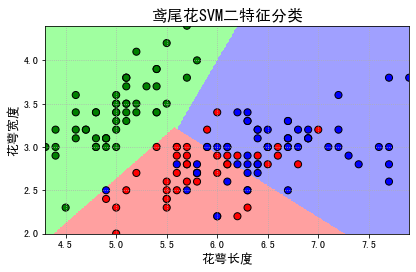

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
import os

data_path = os.path.join("data")
iris_feature = u'花萼长度', u'花萼宽度', u'花瓣长度', u'花瓣宽度'

data = pd.read_csv(os.path.join(data_path, "iris.data"), header=None)
x, y = data[np.arange(4)], data[4]
y = pd.Categorical(y).codes
x = x[[0, 1]]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.4)

# 分类器
tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
    {'kernel': ['poly'], 'C': [1, 10, 100, 1000]}
]

cv = StratifiedKFold(4)
cv.get_n_splits(x_train, y_train)
clf = GridSearchCV(svm.SVC(), param_grid=tuned_parameters, cv=cv)
clf.fit(x_train, y_train.ravel())

# 准确率
print(clf.best_params_)
print('训练集得分：', clf.score(x_train, y_train))  # 精度
print('训练集准确率：', accuracy_score(y_train, clf.predict(x_train)))
print('测试集得分', clf.score(x_test, y_test))
print('测试集准确率：', accuracy_score(y_test, clf.predict(x_test)))

y_test_hat = clf.predict(x_test)
y_test = y_test.reshape(-1)
result = (y_test_hat == y_test)   # True则预测正确，False则预测错误
acc = np.mean(result)
print('准确度: %.2f%%' % (100 * acc))

# 画图
x1_min, x2_min = x.min()
x1_max, x2_max = x.max()
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]  # 生成网格采样点
grid_test = np.stack((x1.flat, x2.flat), axis=1)  # 测试点
grid_hat = clf.predict(grid_test)       # 预测分类值
grid_hat = grid_hat.reshape(x1.shape)  # 使之与输入的形状相同
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

cm_light = mpl.colors.ListedColormap(['#A0FFA0', '#FFA0A0', '#A0A0FF'])
cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])
plt.figure(facecolor='w')
plt.pcolormesh(x1, x2, grid_hat, cmap=cm_light)
plt.scatter(x[0], x[1], c=y, edgecolors='k', s=50, cmap=cm_dark)      # 样本
plt.scatter(x_test[0], x_test[1], s=120, facecolors='none', zorder=10)     # 圈中测试集样本
plt.xlabel(iris_feature[0], fontsize=13)
plt.ylabel(iris_feature[1], fontsize=13)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.title(u'鸢尾花SVM二特征分类', fontsize=16)
plt.grid(b=True, ls=':')
plt.tight_layout(pad=1.5)

# 5.对曲线进行回归

Fit OK.


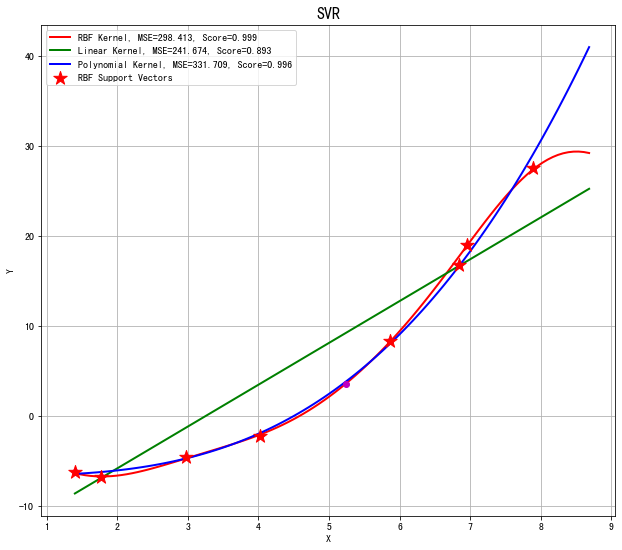

In [3]:
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(linewidth=1000)
N = 9
x = np.linspace(0, 8, N) + np.random.randn(N)
x = np.sort(x)
y = x**2 - 4*x - 3 + np.random.randn(N)
x.shape = -1, 1
y.shape = -1, 1

svr_rbf = svm.SVR(kernel='rbf', gamma=0.2, C=100)
svr_rbf.fit(x, y.ravel())

svr_linear = svm.SVR(kernel='linear', C=100)
svr_linear.fit(x, y.ravel())

svr_poly = svm.SVR(kernel='poly', degree=3, C=100)
svr_poly.fit(x, y.ravel())
print('Fit OK.')

# 思考：系数1.1改成1.5
x_test = np.linspace(x.min(), 1.1*x.max(), 100).reshape(-1, 1)
y_rbf = svr_rbf.predict(x_test)
y_linear = svr_linear.predict(x_test)
y_poly = svr_poly.predict(x_test)

plt.figure(figsize=(9, 8), facecolor='w')
mse = np.average((y_rbf - np.array(y)) ** 2)
s = svr_rbf.score(x, y.ravel())
plt.plot(x_test, y_rbf, 'r-', linewidth=2, label='RBF Kernel, MSE=%.3f, Score=%.3f' % (mse,s))
mse = np.average((y_linear - np.array(y)) ** 2)
s = svr_linear.score(x, y)
plt.plot(x_test, y_linear, 'g-', linewidth=2, label='Linear Kernel, MSE=%.3f, Score=%.3f' % (mse,s))
mse = np.average((y_poly - np.array(y)) ** 2)
s = svr_poly.score(x, y)
plt.plot(x_test, y_poly, 'b-', linewidth=2, label='Polynomial Kernel, MSE=%.3f, Score=%.3f' % (mse,s))
plt.plot(x, y, 'mo', markersize=6)
plt.scatter(x[svr_rbf.support_], y[svr_rbf.support_], s=200, c='r', marker='*', label='RBF Support Vectors', zorder=10)
plt.legend(loc='upper left')
plt.title('SVR', fontsize=16)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.tight_layout(2)